# Hypothesis Testing of Human Height Data

In this lab, you will learn how to use Python 3 to perform and understand the basics of hypothesis testing. Hypothesis testing is widely used. Anytime you are trying to determine if a parameter or relationship is statistically significant you can perform a hypothesis test. 

In this lab you will explore and perform hypothesis tests on a famous data set collect by Frances Galton, who invented the regression method. Galton collected these data from Families living in late 19th century London.  Gaulton published his famous paper in 1885, showing that the highs of adult children regressed to the mean of the population, regardless of the heights of the parents. From this seminal study we have the term regression in statistics, 

## Exercise 1. Explore the data

In this first exercise you will load the Galton data set. You will then and explore differences between some of the variables in these data using some simple visulaizaiton technques. 

****
**Note:** Data visualization is convered in subsequent modules of this course. 

### Load and examine the data set

Execute the code in the cell below to load the Gaulton data set. 

In [1]:
from azureml import Workspace

ws = Workspace()
ds = ws.datasets['GaltonFamilies.csv']
galton = ds.to_dataframe()

With the data loaded, you can examine the first few rows by executing the code in the cell below:

In [2]:
galton.head()

,Case,family,father,mother,midparentHeight,children,childNum,gender,childHeight
0,1,1,78.5,67.0,75.43,4,1,male,73.2
1,2,1,78.5,67.0,75.43,4,2,female,69.2
2,3,1,78.5,67.0,75.43,4,3,female,69.0
3,4,1,78.5,67.0,75.43,4,4,female,69.0
4,5,2,75.5,66.5,73.66,4,1,male,73.5


This data set has 9 features:
 1. A case or row number.
 2. A unique code for each family in the sample.
 3. The height of the father in inches.
 4. The height of the mother in inches.
 5. The average height of the parents.
 6. The number of childern in the family.
 7. A code for the each unique child in the family.
 8. The gender of the child.
 9. The height of the adult child in inches. 
 
 Execute the code in the cell below to determine the number of cases in this data set.

In [3]:
galton.shape

(934, 9)

There are a total of 934 cases, or childern, in the sample comprising this data set. 

### Visualizing some relationships in these data

To develop a better understanding of some of the relationships in these data you will create and compare some histograms of some of the variables. 

The code in the cell below creates a pair of histograms to compare the distributions of two variables. The historgrams are ploted on the same horizontal scale to aid in comparison. A red line is plotted at the mean value of each variable. 

Exectue the code in the cell below to plot a pair of histograms comparing the hight of mothers to the height of  their sons. You can safely ignore any warnings about building a font cache. 

['childHeight', 'mother']

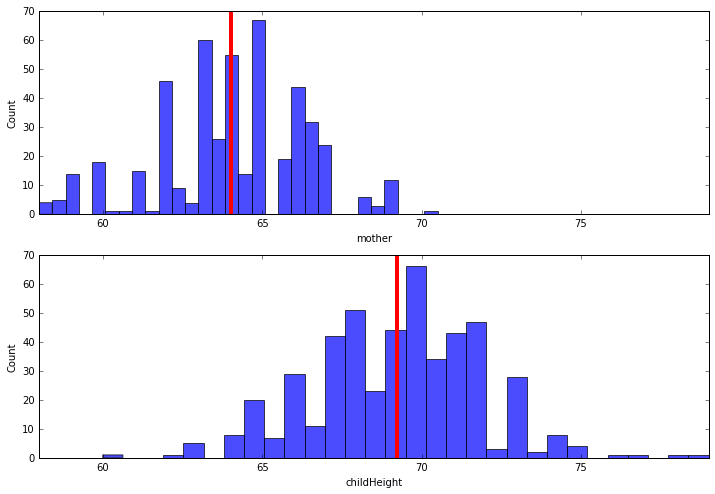

In [4]:
%matplotlib inline
def hist_family(df, col1, col2, num_bins = 30):
    import matplotlib.pyplot as plt
    ## Setup for ploting two charts one over the other
    fig, ax = plt.subplots(2, 1, figsize = (12,8))
    
    mins = min([df[col1].min(), df[col2].min()])
    maxs = max([df[col1].max(), df[col2].max()])
    
    mean1 = df[col1].mean()
    mean2 = df[col2].mean()
    
    ## Plot the histogram   
    temp = df[col1].as_matrix()
    ax[1].hist(temp, bins = 30, alpha = 0.7)
    ax[1].set_xlim([mins, maxs])
    ax[1].axvline(x=mean1, color = 'red', linewidth = 4)
    ax[1].set_ylabel('Count')
    ax[1].set_xlabel(col1)
    
    ## Plot the histogram   
    temp = df[col2].as_matrix()
    ax[0].hist(temp, bins = 30, alpha = 0.7)
    ax[0].set_xlim([mins, maxs])
    ax[0].axvline(x=mean2, color = 'red', linewidth = 4)
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel(col2)
    
    return [col1, col2]
sons = galton[galton.gender == 'male']
hist_family(sons, 'childHeight', 'mother')

Examine these histogram and note the following:

- The distributions of the height of the mothers and their sons have a fair degree of overlap.
- The mean height of the sons is noticeably greater than the mothers.

Next you will compare the heights of mothers to the heights of their daughters. 

['childHeight', 'mother']

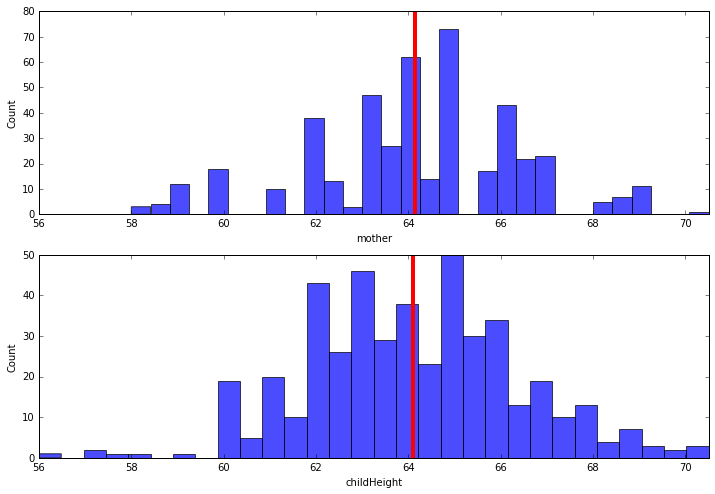

In [5]:
daughters = galton[galton.gender == 'female']
hist_family(daughters, 'childHeight', 'mother')

Examine these histogram and note the following:

- The distributions of the height of the mothers and their daughters overlap almost entirely.
- The mean height of the daughters is nearly the same as the mothers.

In summary, it appears that sons are usually taller than their mothers, whereas, the height of daughters does not appear to be much different from their mothers. But, how valid is this conclusion statistically? 

## Apply t test 

Now that you have examined some of the  relationships between the variables in these data, you will now apply formal hypothesis testing. In hypothesis testing the a null hypothesis is tested against a statistic. The null hypothesis is simply that the difference is not significant. Depending on the value of the test statistic, you can accept or reject the null hypthesis. 

In this case, you will use the two-sided t-test to determine if the difference in means of two variables are significantly different.   The null hypothesis is that there is no significant difference between the means. There are multiple criteria which are used to interpret the test results. You will determine if you can reject the null hyposesis based on the following criteria:

- Selecting a **confidence level** of **5%** or **0.05**.
- Determine if the t-statistic for the degrees of freedom is greater than the **critical value**. The difference in means of Normally distributed variables follows a t-distribution. The large t-statistic indicates the probility that the difference in means is unlikely to be by chance alone. 
- Determine if the P-value is less than the **confidence level**. A small P-value indicates the probability of the difference of the means being more extreme by chance alone is the small. 
- The **confidence interval** around the difference of the means does not overlap with **0**. If the **confidence interval** is far from **0** this indicates that the difference in means is unlikely to include **0**. 

Based on these criteria you will accept of reject the null hypothesis. However, rejecting the null-hypothesis should not be confused with accepting the alternative. It simply means the null is not a good hypothesis. 

The **family_test** function in the cell below uses the **CompareMeans** function from the **weightstats** package to compute the two-sided t statistics. The **hist_family_conf** function calls the **family_test** function and plots the results. Execute this code to compute and  disply the results. 

DegFreedom     9.459687e+02
Difference    -5.200832e+00
Statistic     -3.949802e+01
PValue        6.323181e-153
Low95CI       -5.514333e+00
High95CI      -4.887331e+00
dtype: float64

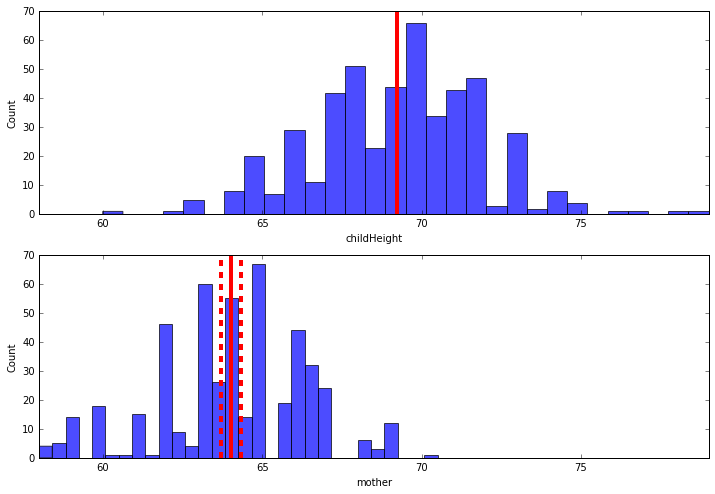

In [6]:
def family_test(df, col1, col2, alpha):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    n, _, diff, var, _, _ = stats.describe(df[col1] - df[col2])
    degfree = n - 1

    temp1 = df[col1].as_matrix()
    temp2 = df[col2].as_matrix()
    res = ss.ttest_rel(temp1, temp2)
      
    means = ws.CompareMeans(ws.DescrStatsW(temp1), ws.DescrStatsW(temp2))
    confint = means.tconfint_diff(alpha=alpha, alternative='two-sided', usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
    
def hist_family_conf(df, col1, col2, num_bins = 30, alpha =0.05):
    import matplotlib.pyplot as plt
    ## Setup for ploting two charts one over the other
    fig, ax = plt.subplots(2, 1, figsize = (12,8))
    
    mins = min([df[col1].min(), df[col2].min()])
    maxs = max([df[col1].max(), df[col2].max()])
    
    mean1 = df[col1].mean()
    mean2 = df[col2].mean()
    
    tStat = family_test(df, col1, col2, alpha)
    pv1 = mean2 + tStat[4]    
    pv2 = mean2 + tStat[5]
    
    ## Plot the histogram   
    temp = df[col1].as_matrix()
    ax[1].hist(temp, bins = 30, alpha = 0.7)
    ax[1].set_xlim([mins, maxs])
    ax[1].axvline(x=mean1, color = 'red', linewidth = 4)    
    ax[1].axvline(x=pv1, color = 'red', linestyle='--', linewidth = 4)
    ax[1].axvline(x=pv2, color = 'red', linestyle='--', linewidth = 4)
    ax[1].set_ylabel('Count')
    ax[1].set_xlabel(col1)
    
    ## Plot the histogram   
    temp = df[col2].as_matrix()
    ax[0].hist(temp, bins = 30, alpha = 0.7)
    ax[0].set_xlim([mins, maxs])
    ax[0].axvline(x=mean2, color = 'red', linewidth = 4)
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel(col2)
    
    return tStat

hist_family_conf(sons, 'mother', 'childHeight')

##### Examine the printed table of results and the charts noting the following:

- The difference of the means is 5.2 inches. You can see this difference graphically by comparing the positions of the solid red lines showing the means of the two distirbutions. 
- The **critical value** of the two-sided t-statistic at  945 degrees of freedom is **1.96**. The t-statistic of -39.5 is larger than this **critical value**.
- The P-value is effectively 0, which is smaller than the **confidence level** of 0.05. 
- The 95% **confidence interval** of the difference in means is from -4.9 to -5.5, which does not overlap 0. You can see the confidence interval plotted as the two dashed red lines in the lower chart shown above. This **confidence interval** around the mean of the mother's heights does not overlap with the mean of the son's height. 

Overall, these statistics indicate you can reject the null hypothesis, or that there difference in the means is not **0**. 

DegFreedom    902.412325
Difference      0.044812
Statistic       0.350524
PValue          0.726109
Low95CI        -0.256132
High95CI        0.345756
dtype: float64

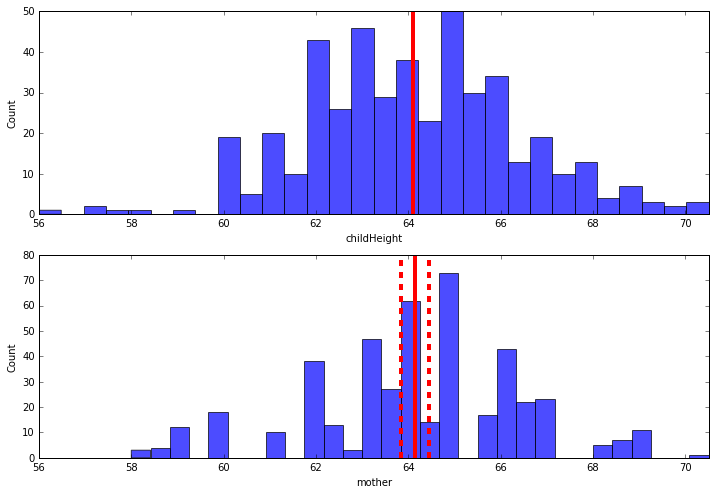

In [7]:
hist_family_conf(daughters, 'mother', 'childHeight')

Examine the printed table of results, which are quite differnt from the test of the heights of mothers vs. sons. Examine the statistics and charts noting the following:

- The difference of the means is only 0.04 inches. You can see this small difference graphically by comparing the positions of the solid red lines showing the means of the two distributions. 
- The **critical value** of the two-sided t-statistic at  480 degrees of freedom is **1.96**. The t-statistic of 0.35 is smaller than this **critical value**.
- The P-value is 0.73, which is larger than the **confidence level** of 0.05. 
- The 95% **confidence interval** of the difference is from -0.26 to 0.35, which overlaps 0. You can see the confidence interval plotted as the two dashed red lines in the lower chart shown above. This **confidence interval** around the mean of the mother's heights does overlaps the mean of the dauther's height. 

Overall, these statistics indicate you cannot reject the null hypothesis that there are is not a significant difference in the means. 

**Evaluation question**

You have found that you could not reject the null hypothesis that there was no significant difference between the heights of mothers and their adult dauhters. But what about the difference in height between fathers and their adult daughters? Perform the t-test on the Galton data set to answer the question below:

- Can you reject the null hypothesis that there is no significant difference in the heights of fathers and their adult daughters.

DegFreedom     8.919930e+02
Difference     5.156291e+00
Statistic      4.086498e+01
PValue        7.001247e-154
Low95CI        4.829558e+00
High95CI       5.483025e+00
dtype: float64

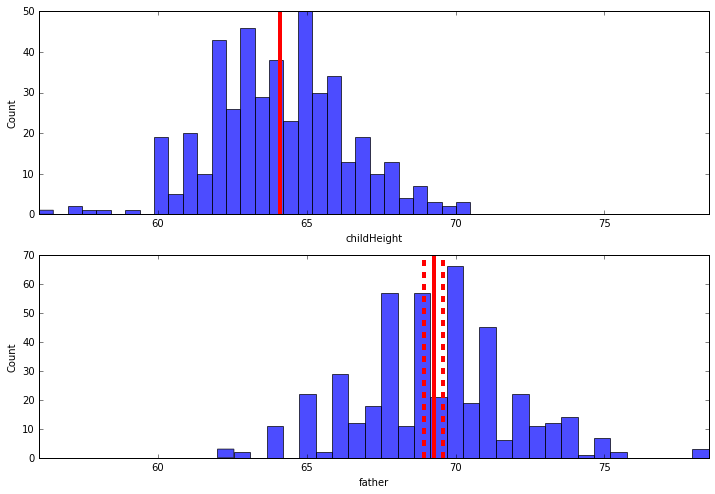

In [10]:
hist_family_conf(daughters, 'father', 'childHeight')